# CycleGAN - Horse2Zebra

---

In this notebook will learn about Generative Adversarial Networks by implementing a Cycle GAN to transfer styles from Horse to Zebra.

**Important:** Set the Colab environment to run on GPU

Authors: Bargallo Enric, Navarro Alex, Planas Ramon, Treviño Nuria

Based on SIMPLE GAN colab from: Albert Pumarola

In [1]:
# Import packages
%load_ext autoreload
%matplotlib inline
%autoreload 2

import os
import time
import random
import torch
import itertools
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets, utils
from torch.utils.data import Dataset, DataLoader
from torch.nn import init
from IPython.display import display
from PIL import Image
import numpy as np
import math
import matplotlib.pyplot as plt

# Check available GPU memory
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 


  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=48d6427870470e770650da43353ee932520b51ad6f93d6fa32a431473bd70109
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.7 GB  | Proc size: 275.3 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


## Utils
Some utils with minor importance

In [0]:
def init_weights(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
          init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

def display_batch_images(img, imtype=np.uint8, unnormalize=True, nrows=None, mean=0.5, std=0.5):
    # select a sample or create grid if img is a batch
    img = img[:4] # Only show first 4 images
    if len(img.shape) == 4:
        nrows = nrows if nrows is not None else int(math.sqrt(img.size(0)))
        img = utils.make_grid(img, nrow=nrows)

    # unnormalize
    img = img.cpu().float()
    img = (img*std+mean)*255

    # to numpy
    image_numpy = img.numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    display(Image.fromarray(image_numpy.astype(imtype))) 

def save_batch_images(img, im_name, imtype=np.uint8, unnormalize=True, mean=0.5, std=0.5):
    # unnormalize
    img = img.cpu().float()
    img = (img*std+mean)*255
    img = utils.make_grid(img, nrow=1)

    # to numpy
    image_numpy = img.numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    
    im = Image.fromarray(image_numpy.astype(imtype))
    im.save(im_name)

## Dataset
Download and prepare datasets (horse2zebra and barcelona2madrid)


In [3]:
# Download horse2zebra
!mkdir -p ./datasets
!wget -N https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip -O ./datasets/horse2zebra.zip

# Unzip dataset
!unzip ./datasets/horse2zebra.zip -d ./datasets/


for details.

--2020-04-08 15:57:45--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘./datasets/horse2zebra.zip’

./datasets/horse2ze 100%[===================>] 111.45M  98.4MB/s    in 1.1s    

2020-04-08 15:57:46 (98.4 MB/s) - ‘./datasets/horse2zebra.zip’ saved [116867962/116867962]

Archive:  ./datasets/horse2zebra.zip
   creating: ./datasets/horse2zebra/
   creating: ./datasets/horse2zebra/trainA/
  inflating: ./datasets/horse2zebra/trainA/n02381460_6223.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_1567.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_3354.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_299.jpg  
  inflating: ./datasets/h

In [4]:
# Download barcelona2madrid
!pip install -U -q PyDrive
file_id = "1DTwhwVxta0KK7UPJPHj1YwVA3XmAd2Ju" # final version

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download file
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('./datasets/barcelona2madrid.zip')

# Unzip dataset
!unzip ./datasets/barcelona2madrid.zip -d ./datasets/

# Rename folders
!mv ./datasets/fcBarcelona2fcRealMadrid/ ./datasets/barcelona2madrid


Archive:  ./datasets/barcelona2madrid.zip
   creating: ./datasets/fcBarcelona2fcRealMadrid/
   creating: ./datasets/fcBarcelona2fcRealMadrid/testA/
  inflating: ./datasets/fcBarcelona2fcRealMadrid/testA/1201_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid/testA/1202_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid/testA/1203_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid/testA/1204_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid/testA/1205_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid/testA/1206_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid/testA/1207_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid/testA/1208_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid/testA/1209_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid/testA/1210_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid/testA/1211_Barcelona.jpg  
  inflating: ./d

**Generate Dataset class**

In [0]:
class TwoDatasets(Dataset):
  """
  Dataset class to get samples from two different image collections
  """
  def __init__(self, root_dirA, root_dirB, batch_size, transform= None):
    self.root_dirA = root_dirA
    self.root_dirB = root_dirB
    self.filelistA = os.listdir(self.root_dirA)
    self.filelistB = os.listdir(self.root_dirB)
    self.transform = transform
    self.batch_size = batch_size

  def __len__(self):
    if len(self.filelistA) < len(self.filelistB):
      num_img = int(len(self.filelistA)/self.batch_size) * self.batch_size
    else:
      num_img = int(len(self.filelistB)/self.batch_size) * self.batch_size
    return num_img

  def __getitem__(self,idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_nameA = os.path.join(self.root_dirA, self.filelistA[idx])
    img_nameB = os.path.join(self.root_dirB, self.filelistB[idx])

    imageA = Image.open(img_nameA).convert('RGB')
    imageB = Image.open(img_nameB).convert('RGB')

    if self.transform:
      imageA = self.transform(imageA)
      imageB = self.transform(imageB)

    return imageA, imageB


Generate datasets for train & test

In [0]:
image_size = 128
batch_size = 10
tf_train = transforms.Compose(
    [transforms.Resize(int(image_size*1.12), interpolation=Image.BICUBIC),
     transforms.RandomHorizontalFlip(),
     transforms.CenterCrop(image_size),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
    )
image_size_test = 256
batch_size_test = 1
tf_test = transforms.Compose(
    [transforms.Resize(int(image_size_test*1.12), interpolation=Image.BICUBIC),
     transforms.CenterCrop(image_size_test),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
    )

# Horse2Zebra
horse2zebra_train = TwoDatasets('./datasets/horse2zebra/trainA', './datasets/horse2zebra/trainB', batch_size, transform=tf_train)
horse2zebra_test  = TwoDatasets('./datasets/horse2zebra/testA',  './datasets/horse2zebra/testB',  batch_size_test, transform=tf_test)

# Barcelona2Madrid
barcelona2madrid_train = TwoDatasets('./datasets/barcelona2madrid/trainA', './datasets/barcelona2madrid/trainB', batch_size, transform=tf_train)
barcelona2madrid_test  = TwoDatasets('./datasets/barcelona2madrid/testA',  './datasets/barcelona2madrid/testB',  batch_size_test, transform=tf_test)

## Data Loader
Create data loaders for the horse2zebra & barcelona2madrid dataset

In [0]:
# Horse2Zebra
data_loader_train = torch.utils.data.DataLoader(horse2zebra_train, batch_size=batch_size, shuffle=True)
data_loader_test  = torch.utils.data.DataLoader(horse2zebra_test,  batch_size=batch_size_test, shuffle=False)

# Barcelona2Madrid
data_loader_train = torch.utils.data.DataLoader(barcelona2madrid_train, batch_size=batch_size, shuffle=True)
data_loader_test  = torch.utils.data.DataLoader(barcelona2madrid_test,  batch_size=batch_size_test, shuffle=False)



Show some examples

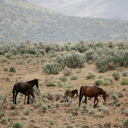

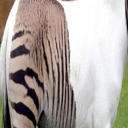

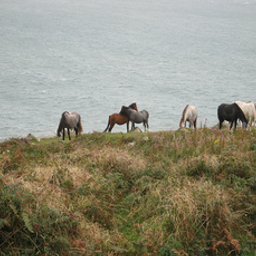

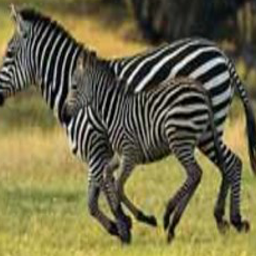

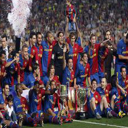

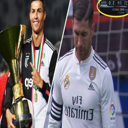

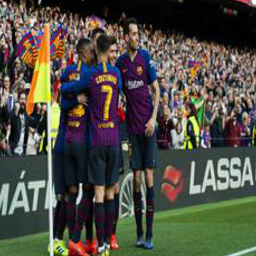

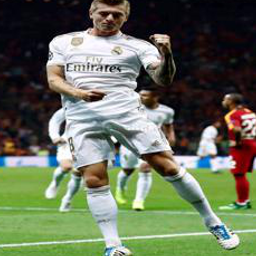

In [8]:
# Display images
display_batch_images(horse2zebra_train[0][0])
display_batch_images(horse2zebra_train[0][1])
#
display_batch_images(horse2zebra_test[0][0])
display_batch_images(horse2zebra_test[0][1])
#
display_batch_images(barcelona2madrid_train[0][0])
display_batch_images(barcelona2madrid_train[0][1])
#
display_batch_images(barcelona2madrid_test[0][0])
display_batch_images(barcelona2madrid_test[0][1])

## Networks

Generator from Cycle GAN paper

In [0]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()

        # ENCODING
        self._encoder1 = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        self._encoder2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )
        self._encoder3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )

        # TRANSFORMATION (RESNET)
        out_channels = 256
        self._res1 = self.residual(out_channels, out_channels, 3)
        self._res2 = self.residual(out_channels, out_channels, 3)
        self._res3 = self.residual(out_channels, out_channels, 3)
        self._res4 = self.residual(out_channels, out_channels, 3)
        self._res5 = self.residual(out_channels, out_channels, 3)
        self._res6 = self.residual(out_channels, out_channels, 3)

        # DECODING
        self._decoder1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )
        self._decoder2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        self._decoder3 = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=7, padding=0),
            nn.Tanh()
        )

    def residual(self, i, o, dim):
        x = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(i, o, kernel_size=dim, padding=0, bias=False),
            nn.BatchNorm2d(o),
            nn.ReLU(True),        
            nn.ReflectionPad2d(1),
            nn.Conv2d(i, o, kernel_size=dim, padding=0, bias=False),
            nn.BatchNorm2d(o),
        )
        return x

    def forward(self, x):
        # Encode -> Transform -> Decode
        # Encoding
        x = self._encoder1(x)
        x = self._encoder2(x)
        x = self._encoder3(x)

        # Transformation: Resnet blocks
        a = x + self._res1(x)
        b = a + self._res2(a)
        c = b + self._res3(b)
        d = c + self._res4(c)
        e = d + self._res5(d)
        x = e + self._res6(e)

        # Decoding
        x = self._decoder1(x)
        x = self._decoder2(x)
        x = self._decoder3(x)

        return x

Discriminator from Cycle GAN paper

In [0]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self._conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1, bias=True)
        )

    def forward(self, x):
        # Classify image as fake or real
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)
        x = self._conv4(x)
        output = self._conv5(x)

        return output

## Model
Now lets create the core of our task, the model.  Remember Cycle GANs loss:
$\mathcal{L}_{GAN}(G,D_Y,X,Y)=\mathbb{E}_{y\sim p_{data}(y)}\big[logD_Y(y)\big] + \mathbb{E}_{x\sim p_{data}(x)}\big[log(1-D_Y(G(x)))\big]$

$\mathcal{L}_{cyc}(G,F)=\mathbb{E}_{x\sim p_{data}(x)}\big[||F(G(x))-x||_1\big] + \mathbb{E}_{y\sim p_{data}(y)}\big[||G(F(y))-y||_1\big]$

$\mathcal{L}_{idt}(G,F)=\mathbb{E}_{y\sim p_{data}(y)}\big[||G(y)-y||_1\big] + \mathbb{E}_{x\sim p_{data}(x)}\big[||F(x)-x||_1\big]$

The full objective is:

$\mathcal{L}(G,F,D_X,D_Y)=\mathcal{L}_{GAN}(G,D_Y,X,Y) + \mathcal{L}_{GAN}(F,D_X,Y,X) + \lambda_{cyc}\mathcal{L}_{cyc}(G,F) + \lambda_{idt}\mathcal{L}_{idt}(G,F)$

In [0]:
class Model:
    # --------------------------
    # -- PREPARE MODEL
    # --------------------------
    
    def __init__(self, batch_size):
        self._create_networks()
        self._create_optimizers()
        self._init_criterion(batch_size)
        
    def _create_networks(self):
        # create networks
        self._generatorA2B = Generator()
        self._generatorB2A = Generator()
        self._discriminatorA = Discriminator()
        self._discriminatorB = Discriminator()

        # init weights
        self._generatorA2B.apply(init_weights)
        self._generatorB2A.apply(init_weights)
        self._discriminatorA.apply(init_weights)
        self._discriminatorB.apply(init_weights)

        # move to cuda
        self._generatorA2B.cuda()
        self._generatorB2A.cuda()
        self._discriminatorA.cuda()
        self._discriminatorB.cuda()

    def _create_optimizers(self):
        # generators optimizers
        # Look for param groups
        self._opt_gen = torch.optim.Adam(
            itertools.chain(self._generatorA2B.parameters(), self._generatorB2A.parameters()), lr=0.0002, betas=(0.5, 0.999)
        )

        # discriminators optimizers
        self._opt_discr = torch.optim.Adam(
            itertools.chain(self._discriminatorA.parameters(), self._discriminatorB.parameters()), lr=0.0002, betas=(0.5, 0.999)
        )
        
    def _init_criterion(self, batch_size):
        self._criterionGAN = nn.MSELoss() # To fight vanishing gradients better MSELoss than BCELoss
        self._criterionCYC = nn.L1Loss()  # L1 for Cycle Consistency Loss
        self._criterionIDT = nn.L1Loss()  # L1 for Identity Loss
        #####
        size_out = 14 # 14 for images 128x128 and 30 for images 256x256
        #####
        self._label_real = Variable(torch.ones(batch_size, 1, size_out, size_out)).cuda()
        self._label_fake = Variable(torch.zeros(batch_size, 1, size_out, size_out)).cuda()
        
    # --------------------------
    # -- Optimize Model
    # --------------------------
        
    def step_optimization(self, real_samplesA, real_samplesB, lambda_cyc, lambda_idt):
    
        # generate fake_samples
        fake_samplesA2B = self._generatorA2B(real_samplesA)
        fake_samplesB2A = self._generatorB2A(real_samplesB)
    
        idt_samplesA    = self._generatorA2B(real_samplesB)
        idt_samplesB    = self._generatorB2A(real_samplesA)

        cyc_samplesA    = self._generatorB2A(fake_samplesA2B)
        cyc_samplesB    = self._generatorA2B(fake_samplesB2A)
    
        #
        # Optimize generators
        #
        # Reset gradients
        self._opt_gen.zero_grad()
    
        # discriminators are not updated
        for params in self._discriminatorA.parameters():
          params.requires_grad = False
        for params in self._discriminatorB.parameters():
          params.requires_grad = False

        estim_fakeA = self._discriminatorA(fake_samplesA2B)
        loss_gA = self._criterionGAN(estim_fakeA, self._label_real)
        estim_fakeB = self._discriminatorB(fake_samplesB2A)
        loss_gB = self._criterionGAN(estim_fakeB, self._label_real)
        #
        # Cycle loss
        #
        loss_cycA = self._criterionCYC(real_samplesA, cyc_samplesA) * lambda_cyc
        loss_cycB = self._criterionCYC(real_samplesB, cyc_samplesB) * lambda_cyc
        #
        # Identity loss
        #
        loss_idtA = self._criterionIDT(idt_samplesA, real_samplesB) * lambda_idt
        loss_idtB = self._criterionIDT(idt_samplesB, real_samplesA) * lambda_idt
        #
        loss_g = loss_gA + loss_gB + loss_cycA + loss_cycB + loss_idtA + loss_idtB
        #
        loss_g.backward()
        self._opt_gen.step()

        #
        # Optimize discriminators
        #
        # Reset gradients
        self._opt_discr.zero_grad()

        # discriminators are updated
        for params in self._discriminatorA.parameters():
          params.requires_grad = True
        for params in self._discriminatorB.parameters():
          params.requires_grad = True

        #
        # optimize discriminator A
        #  
        # Calculate discriminator A loss for real samples B
        estim_realA = self._discriminatorA(real_samplesB)
        loss_realA = self._criterionGAN(estim_realA, self._label_real)
    
        # Calculate discriminator A loss for fake samples A2B
        estim_fakeA = self._discriminatorA(fake_samplesA2B.detach())
        loss_fakeA = self._criterionGAN(estim_fakeA, self._label_fake)
    
        # Total discriminator loss
        loss_dA = (loss_realA + loss_fakeA) / 2
        loss_dA.backward()
        
        #
        # optimize discriminator B
        #
        # Calculate discriminator B loss for real samples A
        estim_realB = self._discriminatorB(real_samplesA)
        loss_realB = self._criterionGAN(estim_realB, self._label_real)
    
        # Calculate discriminator B loss for fake samples B2A
        estim_fakeB = self._discriminatorB(fake_samplesB2A.detach())
        loss_fakeB = self._criterionGAN(estim_fakeB, self._label_fake)
    
        # Total discriminator loss
        loss_dB = (loss_realB + loss_fakeB) / 2
        loss_dB.backward()

        self._opt_discr.step()
    
        return loss_gA.item(), loss_gB.item(), loss_dA.item(), loss_dB.item(), loss_cycA.item(), loss_cycB.item(), loss_idtA.item(), loss_idtB.item()


## Train

In [45]:
# Generate model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Set hyperparameters
num_epochs = 200               # Number of epochs
lambda_cyc = 10                # Lambda for cyclic loss
lambda_idt = lambda_cyc * 0.5  # Lambda for identity loss 
output_test_images = True      # Output of images from test dataset (True or False)
output_test_epoch = 5          # Frequency of epochs to output test images

# Create model
model = Model(batch_size)
print(f"Number of parameters GeneratorA2B:   {count_parameters(model._generatorA2B)}")
print(f"Number of parameters GeneratorB2A:   {count_parameters(model._generatorB2A)}")
print(f"Number of parameters DiscriminatorA: {count_parameters(model._discriminatorA)}")
print(f"Number of parameters DiscriminatorB: {count_parameters(model._discriminatorB)}")


Number of parameters GeneratorA2B:   7841411
Number of parameters GeneratorB2A:   7841411
Number of parameters DiscriminatorA: 2765633
Number of parameters DiscriminatorB: 2765633


In [46]:
# Initialize arrays to store losses for plotting
GA_loss = []
CYCA_loss = []
IDTA_loss = []
DA_loss = []
GB_loss = []
CYCB_loss = []
IDTB_loss = []
DB_loss = []
#
if output_test_images:
    !mkdir -p './results'
    !mkdir -p './results/testA'
    !mkdir -p './results/testB'
    output_pathA = './results/testA/'
    output_pathB = './results/testB/'
#
for epoch in range(num_epochs):
    # Start timer
    epoch_time = time.time()

    # Train epoch
    for n_batch, (real_samplesA, real_samplesB) in enumerate(data_loader_train):

        # Prepare batch data
        real_samplesA = Variable(real_samplesA).cuda()
        real_samplesB = Variable(real_samplesB).cuda()

        # Update model weights
        loss_gA, loss_gB, loss_dA, loss_dB, loss_cycA, loss_cycB, loss_idtA, loss_idtB = model.step_optimization(
            real_samplesA, real_samplesB, lambda_cyc, lambda_idt)

        # Array with losses for plotting
        GA_loss.append(loss_gA)
        CYCA_loss.append(loss_cycA)
        IDTA_loss.append(loss_idtA)
        DA_loss.append(loss_dA)
        #
        GB_loss.append(loss_gB)
        CYCB_loss.append(loss_cycB)
        IDTB_loss.append(loss_idtB)
        DB_loss.append(loss_dB)
        
        # Show fake samples
        if n_batch == 10 and (epoch) % 5 == 0:
            fakeA = model._generatorA2B(real_samplesA)
            fakeB = model._generatorB2A(fakeA)
            display_batch_images(real_samplesA)
            display_batch_images(fakeA.detach())
            display_batch_images(fakeB.detach())
            #
            fakeB = model._generatorB2A(real_samplesB)
            fakeA = model._generatorA2B(fakeB)
            display_batch_images(real_samplesB)
            display_batch_images(fakeB.detach())
            display_batch_images(fakeA.detach())

    # Output test images
    if (epoch) % output_test_epoch == 0:
        # Start timer
        output_time = time.time()
        #
        print('Output test images at epoch %s' % epoch)
        for n_batch_test, (samplesA, samplesB) in enumerate(data_loader_test):
            # Prepare batch data
            samplesA = Variable(samplesA).cuda()
            samplesB = Variable(samplesB).cuda()
            #
            fakeA = model._generatorA2B(samplesA)
            cycA = model._generatorB2A(fakeA)
            # Save images
            save_batch_images(fakeA.detach(), output_pathA+'%s_fakeA_epoch%s.png' % (n_batch_test+1, epoch))
            save_batch_images(cycA.detach(), output_pathA+'%s_cycA_epoch%s.png' % (n_batch_test+1, epoch))
            #
            fakeB = model._generatorB2A(samplesB)
            cycB = model._generatorA2B(fakeB)
            # Save images
            save_batch_images(fakeB.detach(), output_pathB+'%s_fakeB_epoch%s.png' % (n_batch_test+1, epoch))
            save_batch_images(cycB.detach(), output_pathB+'%s_cycB_epoch%s.png' % (n_batch_test+1, epoch))
        print(f"Time taken (s): {time.time()-output_time}")

    # Show current loss
    #if (n_batch) % 100 == 0:
    print(f"epoch: {epoch}/{num_epochs}, batch: {n_batch+1}/{len(data_loader_train)}")
    print(f"       GA_loss: {loss_gA}, DA_loss: {loss_dA}, CYCA_loss: {loss_cycA}, IDTA_loss: {loss_idtA}")
    print(f"       GB_loss: {loss_gB}, DB_loss: {loss_dB}, CYCB_loss: {loss_cycB}, IDTB_loss: {loss_idtB}")
    print(f"Time taken (s): {time.time()-epoch_time}")


Output hidden; open in https://colab.research.google.com to view.

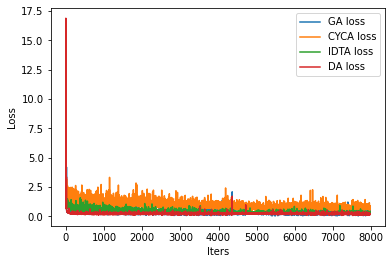

In [0]:
# Plot GAN loss
plt.figure()
plt.ylabel('Loss')
plt.xlabel('Iters')
plt.plot(GA_loss, label='GA loss')
# Plot CYC loss
plt.plot(CYCA_loss, label='CYCA loss')
# Plot IDT loss
plt.plot(IDTA_loss, label='IDTA loss')
# Plot DISC loss
plt.plot(DA_loss, label='DA loss')
plt.legend()